In [32]:
import numpy as np
# todo : 1 go from models to margins
# 2 compute KLOM from margins
from pathlib import Path
import torch as ch

PRECOMPUTE_DIR =Path("/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models")

BASE_ORACLE_MODELS = PRECOMPUTE_DIR / "oracle_models/CIFAR10/"
ORACLE_MODELS = BASE_ORACLE_MODELS/ "forget_set_1"
FULL_MODELS = PRECOMPUTE_DIR / "full_models" / "CIFAR10" 

# list number of models in each dir
print(f"Number of models in {ORACLE_MODELS}:\n {len(list(ORACLE_MODELS.glob('*.pt')))}")
print(f"Number of models in {FULL_MODELS}:\n {len(list(FULL_MODELS.glob('*.pt')))}")

Number of models in /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/forget_set_1:
 5575
Number of models in /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/full_models/CIFAR10:
 1604


In [13]:
from unlearning.unlearning_algos.utils import get_margins
from unlearning.datasets.cifar10 import get_cifar_dataloader
from unlearning.unlearning_algos import utils
from importlib import reload    
reload(utils)




dataloader = get_cifar_dataloader(num_workers=2, indexed=True)
targets = dataloader.dataset.original_dataset.targets

# Example usage:
# logit_path = "path/to/your/logits.pt"
# margins = compute_margins_from_logits(logit_path)
# print(f"Computed margins shape: {margins.shape}")
oracle_logit_path = ORACLE_MODELS / "237__val_logits_23.pt"
original_model_path = FULL_MODELS / "val_logits_237.pt"
oracle_logits = ch.load(example_logit_path)
original_logits = ch.load(original_model_path)



ind = 0
single_logits = logits[ind].unsqueeze(0)
print(single_logits.shape)
label=  targets[ind]
 
example_margin = utils.get_margin_from_logits(single_logits, label)
print(f"Computed margins shape: {example_margin.shape}; {example_margin}")

margins = utils.get_margins_from_logits(logits, targets)
print(f"Computed margins shape: {margins.shape}")

from matplotlib import pyplot as plt
# plot hist
plt.hist(margins.cpu().numpy(), bins=100)
plt.show()


No augmentation
Files already downloaded and verified
torch.Size([10000, 10])


/n/home04/rrinberg/venv_unlearning_bench/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [29]:
all_margins_path = FULL_MODELS / "train_margins_all.pt"
# train_logits_all.pt  train_margins_all.pt 
# val_logits_all.pt  val_margins_all.pt

all_margins = ch.load(all_margins_path)
all_margins.shape

torch.Size([200, 50000])

In [89]:
# we want to do 3 things
# 1. get all the logits for the train set, and save that
# 2. get all the logits for the val set, and save that
# 3. use 1 and 2 to compute margins for each point
# 4. compute KLOM for the oracles and the original model

def __sort_logit_files__train(file_paths):
    """
    Sort logit files based on the first number in the filename.
    Handles numeric sorting correctly (e.g., 4 < 5 < 49 < 400)
    
    Args:
        file_paths: List of Path objects or strings containing filenames like "48__train_logits__23.pt"
        
    Returns:
        Sorted list of file paths
    """
    def get_first_number(filename):
        # Convert Path to string if needed
        filename = str(filename.name)
        # Extract first number before '__'
        first_num = int(filename.split('__')[0])
        return first_num
    
    return sorted(file_paths, key=get_first_number)

def sort_train_logit_files(file_paths):
    """
    Sort validation logit files based on the number in the filename.
    Handles numeric sorting correctly (e.g., val_logits_4.pt < val_logits_5.pt < val_logits_49.pt)
    
    Args:
        file_paths: List of Path objects or strings containing filenames like "val_logits_237.pt"
        
    Returns:
        Sorted list of file paths
    """
    def get_val_number(filename):
        # Convert Path to string if needed
        filename = str(filename)
        num = int(filename.split('train_logits_')[1].split('.')[0])
        return num
    
    return sorted(file_paths, key=get_val_number)


def sort_val_logit_files(file_paths):
    """
    Sort validation logit files based on the number in the filename.
    Handles numeric sorting correctly (e.g., val_logits_4.pt < val_logits_5.pt < val_logits_49.pt)
    
    Args:
        file_paths: List of Path objects or strings containing filenames like "val_logits_237.pt"
        
    Returns:
        Sorted list of file paths
    """
    def get_val_number(filename):
        # Convert Path to string if needed
        filename = str(filename)
        # Extract number after 'val_logits_'
        num = int(filename.split('val_logits_')[1].split('.')[0])
        return num
    
    return sorted(file_paths, key=get_val_number)


forget_set_id = 2
logit_paths = BASE_ORACLE_MODELS / f"forget_set_{forget_set_id}" 
#/ "*__val_logits_all.pt"
print(f"logit_paths: {logit_paths}")
#train_logit_paths = list(logit_paths.glob("*__train_logits__23.pt"))
train_logit_paths = list(logit_paths.glob("train_logits_*.pt"))
# sort
train_logit_paths = sort_train_logit_files(train_logit_paths)
train_margins = []
print(f"loading {len(train_logit_paths)} train logits")
for i, path in enumerate(train_logit_paths):
    if i >200:
        break 
    
    if i % 10 ==0:
        print(f"loading {i} train logits")  
        print(path.name)
    train_logit = ch.load(path)
    margins = utils.get_margins_from_logits(train_logit, targets)
    train_margins.append(margins)
    
    
print(margins.shape)


#oracle_train_logits, oracle_val_logits = get_all_logits__oracle(2)


logit_paths: /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/forget_set_2
loading 500 train logits
/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/forget_set_2/train_logits_0.pt
loading 0 train logits
train_logits_0.pt
/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/forget_set_2/train_logits_1.pt
/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/forget_set_2/train_logits_2.pt
/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/forget_set_2/train_logits_3.pt
/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/forget_set_2/train_logits_4.pt
/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/forget_set_2/train_logits_5.pt
/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/CIFAR10/fo

In [90]:
# I have a list of [50000, 1] tensors, and I want to stack them into a [50000, 100] tensor
train_margins_stack = ch.cat(train_margins, dim=1).T
print(train_margins_stack.shape)
# save 
all_train_margins_path = logit_paths / "train_margins_all.pt"

ch.save(train_margins_stack, all_train_margins_path)

#oracle_train_logits, oracle_val_logits = get_all_logits__oracle(2)



torch.Size([201, 50000])


torch.Size([25000000, 10])

In [60]:

def get_all_logits__original():
    # load `val_margins_all.pt`
    train_margins_path = FULL_MODELS  / "train_margins_all.pt"
    val_margins_path = FULL_MODELS / "val_margins_all.pt"
    train_margins = ch.load(train_margins_path)
    val_margins = ch.load(val_margins_path)
    return train_margins, val_margins

print("getting original logits")
original_train_margins, original_val_margins = get_all_logits__original()
print(f"shapes : {original_train_margins.shape}, {original_val_margins.shape}")

getting original logits
shapes : torch.Size([200, 50000]), torch.Size([200, 10000])


In [91]:
print(train_margins_stack.shape)
original_train_margins.shape


torch.Size([201, 50000])


torch.Size([200, 50000])

forget_set_path - /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/forget_set_inds/CIFAR10/forget_set_2.npy


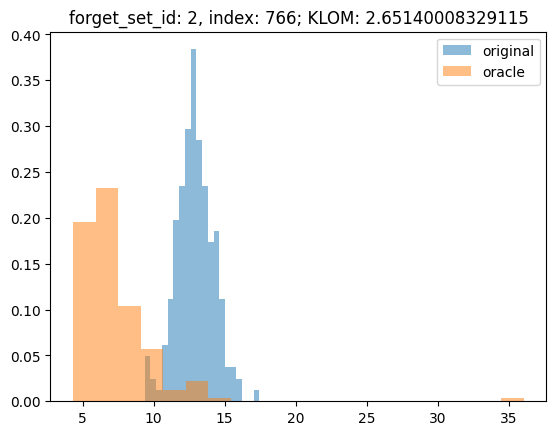

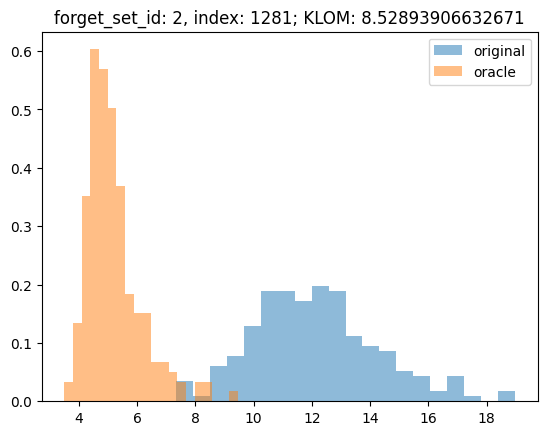

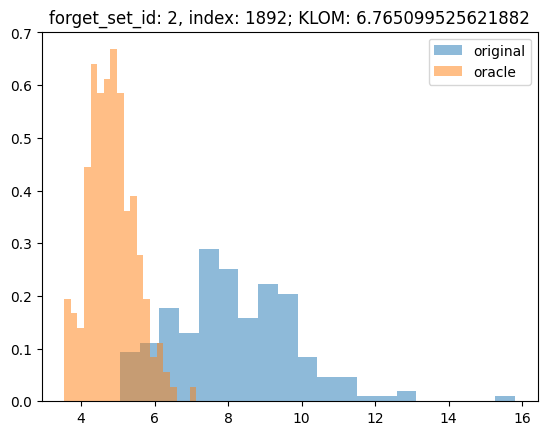

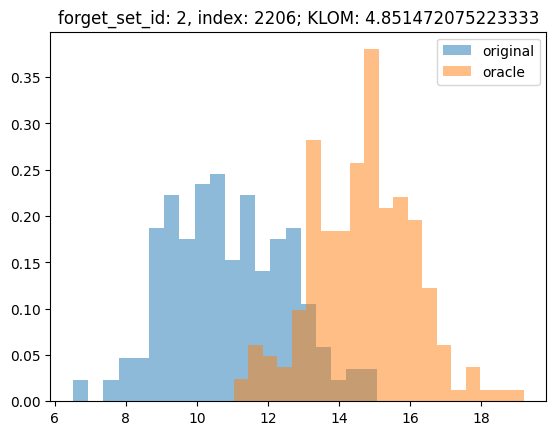

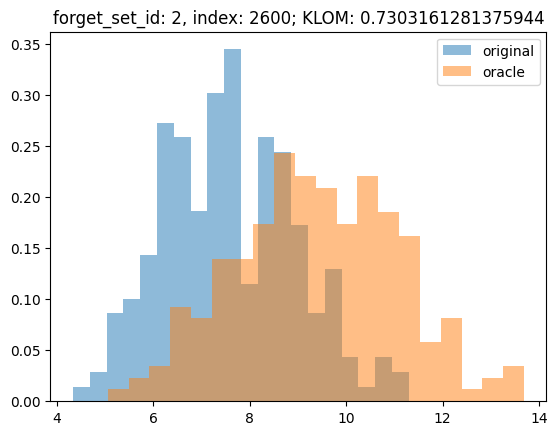

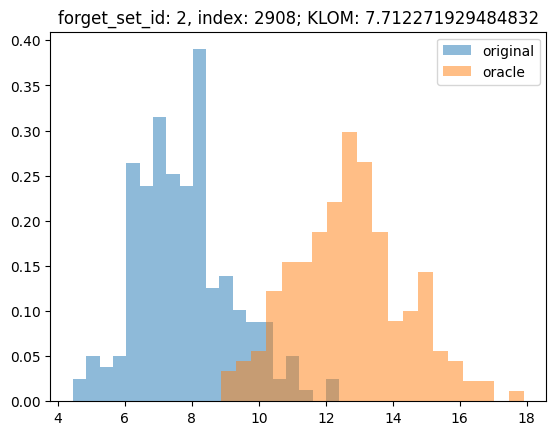

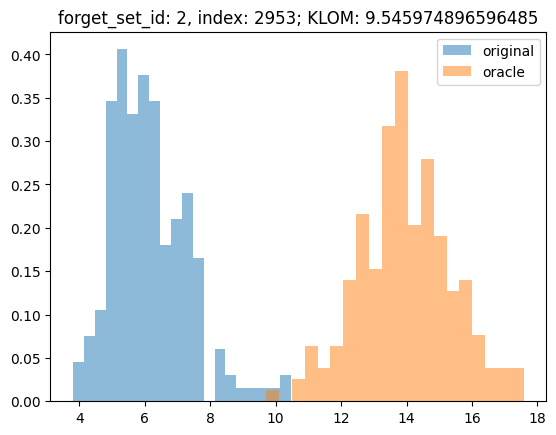

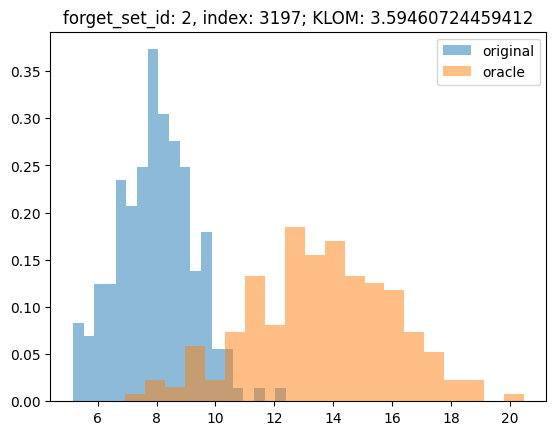

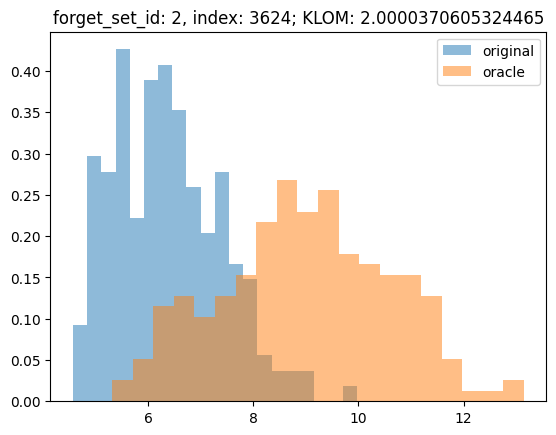

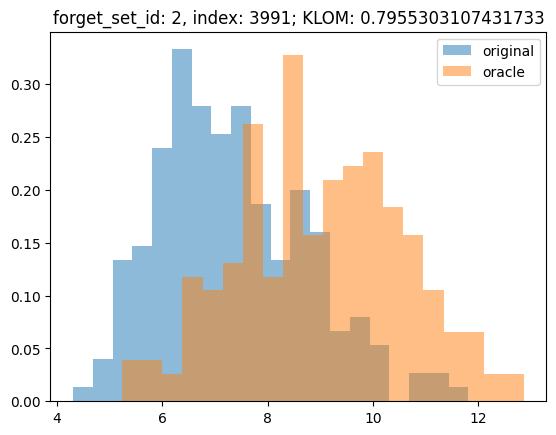

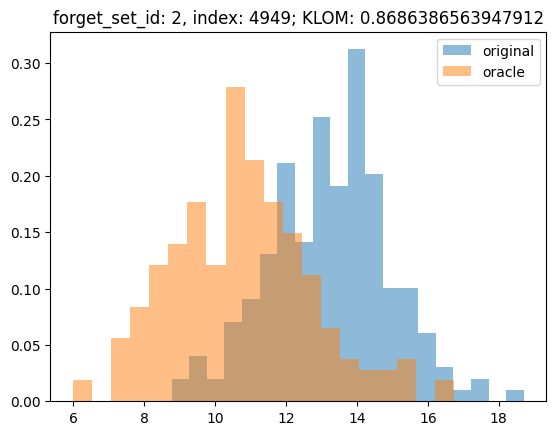

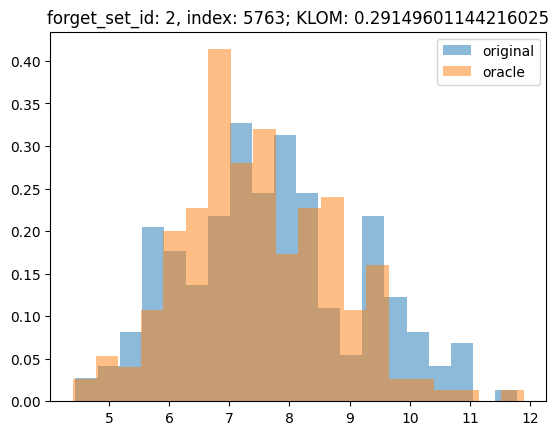

In [95]:
# forget_set_indices
from unlearning.auditors.utils import load_forget_set_indices
from unlearning.auditors import direct
reload(direct)
forget_set_indices = load_forget_set_indices("CIFAR10", forget_set_id, DATA_DIR =PRECOMPUTE_DIR/ "forget_set_inds") 



for ii, index in enumerate(forget_set_indices):
    # plot histogram of margins 
    plt.hist(original_train_margins.T[index], bins=20, alpha=0.5, density =    True, label="original")
    #plt.hist(train_margins_stack.T[index], bins=20, alpha=0.5, density=True, label="oracle")
    plt.hist(original_train_margins.T[index+1], bins=20, alpha=0.5, density=True, label="oracle")

    klom = direct.compute_binned_KL_div(original_train_margins.T[index], original_train_margins.T[index+1])
    plt.legend()
    plt.title(f"forget_set_id: {forget_set_id}, index: {index}; KLOM: {klom[0]}")
    plt.show()
    if ii > 10:
        break





In [79]:
original_train_margins.T[3].shape

torch.Size([200])

In [ ]:
pt_index  = 10
oracle_train_logits.shape

# TODO - issue is likely the ordering
def gext_all_logits__oracle(forget_set_id, targets= targets, save = False):
    # collect all files of the form "*__train_logits__23.pt"
    logit_paths = BASE_ORACLE_MODELS / f"forget_set_{forget_set_id}" 
    #/ "*__val_logits_all.pt"
    print(f"logit_paths: {logit_paths}")
    train_logit_paths = list(logit_paths.glob("*__train_logits__23.pt"))
    train_margins = []
    print(f"loading {len(train_logit_paths)} train logits")
    for i, path in enumerate(train_logit_paths):
        if i % 10 ==0:
            print(f"loading {i} train logits")  
        train_logit = ch.load(path)
        margins = utils.get_margins_from_logits(train_logit, targets)
        
        train_margins.append(margins)
    print(f"single train_logits: {train_margins[0].shape}")
    print(f"number of train logits: {len(train_margins)}")
    
    
    
    val_logit_paths = list(logit_paths.glob("val_logits_*.pt"))
    val_logit_paths = sort_val_logit_files(val_logit_paths)
    val_logits = []
    print(f"loading {len(val_logit_paths)} val logits")
    for path in val_logit_paths:
        val_logits.append(ch.load(path))
    # to torch from list
    train_logits = ch.cat(train_logits)
    val_logits = ch.cat(val_logits)
    train_save_path = BASE_ORACLE_MODELS / "CIFAR10" / f"forget_set_{forget_set_id}" / "train_logits_all.pt"
    val_save_path = BASE_ORACLE_MODELS / "CIFAR10" / f"forget_set_{forget_set_id}" / "val_logits_all.pt"

    if save:
        print(f"saving")
        ch.save(ch.cat(train_logits), train_save_path)
        ch.save(ch.cat(val_logits), val_save_path)
    return train_logits, val_logits